## Portfolio Construction and Analysis with Python - Group Assignment

#### Group Members - Juliette Comby Maha Laabiyad, Sai Vandana, Supreeth Shivakumar

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [40]:
# Defining the tickers and downloading historical data
tickers = [
    "TSLA", "AAPL", "PG", "JPM", "TLT", "IBGL.AS", "MSFT", "EEM", "SPY", "VNQ"
]

# Consider data of the last 10 years
data1 = yf.download(tickers, start="2013-12-01", end="2023-12-01")["Adj Close"]

# Compute daily returns
returns = data1.pct_change().dropna()

# Consider TLT yield as the risk-free rate
tlt_yield = returns['TLT'].mean() * 252  # Annualized risk-free rate

[*********************100%***********************]  10 of 10 completed
/var/folders/mn/3zs_6q7s7zx9ygqzqn83mnjr0000gn/T/ipykernel_10913/3799705672.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data1.pct_change().dropna()


In [42]:
# Portfolio optimization functions - annualized return, annualized volatility, sharpe ratio, cVaR
def portfolio_performance(weights, returns):
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_volatility = np.sqrt(
        np.dot(weights.T, np.dot(returns.cov() * 252, weights))
    )  # Annualized volatility
    return portfolio_return, portfolio_volatility

def sharpe_ratio(weights, returns, risk_free_rate):  # Calculet Sharpe Ratio
    portfolio_return, portfolio_volatility = portfolio_performance(weights, returns)
    return (portfolio_return - risk_free_rate) / portfolio_volatility

def cvar(weights, returns, alpha=0.05):  # Calculate conditional value at risk (cVaR)
    portfolio_returns = np.dot(returns, weights)
    portfolio_returns_sorted = np.sort(portfolio_returns)
    index = int(alpha * len(portfolio_returns_sorted))
    return -portfolio_returns_sorted[:index].mean()

In [44]:
# Optimization constraints
num_assets = len(tickers)
init_guess = np.ones(num_assets) / num_assets
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}  # Sum of weights is equal to 1


In [46]:
# Equally Weighted Portfolio
equal_weights = np.ones(num_assets) / num_assets

In [48]:
# Global Minimum Variance Portfolio
def minimize_volatility(weights):
    return portfolio_performance(weights, returns)[1]

gmv_result = minimize(
    minimize_volatility,
    init_guess,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)
gmv_weights = gmv_result.x

In [50]:
# Maximum Sharpe Ratio Portfolio
def negative_sharpe(weights):
    return -sharpe_ratio(weights, returns, tlt_yield)

msr_result = minimize(
    negative_sharpe,
    init_guess,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)
msr_weights = msr_result.x

In [52]:
# Mean-Variance Portfolio
def negative_return(weights):
    return -portfolio_performance(weights, returns)[0]

target_volatility = 0.15

mean_variance_result = minimize(
    negative_return,
    init_guess,
    method="SLSQP",
    bounds=bounds,
    constraints= [
        constraints,
        {
            "type": "ineq",  # Ensure volatility <= target volatility
            "fun": lambda weights: target_volatility - portfolio_performance(weights, returns)[1]
        },
    ],
)
mv_weights = mean_variance_result.x

In [54]:
# Conditional Value at Risk Portfolio
def cvar_optimization(weights):
    return cvar(weights, returns)

cvar_result = minimize(
    cvar_optimization,
    init_guess,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)
cvar_weights = cvar_result.x

# Combine results into a DataFrame
weights_df = pd.DataFrame(
    {
        "Equally Weighted": equal_weights,
        "Global Minimum Variance": gmv_weights,
        "Maximum Sharpe Ratio": msr_weights,
        "Mean Variance": mv_weights,
        "CVaR": cvar_weights,
    },
    index=tickers,
)


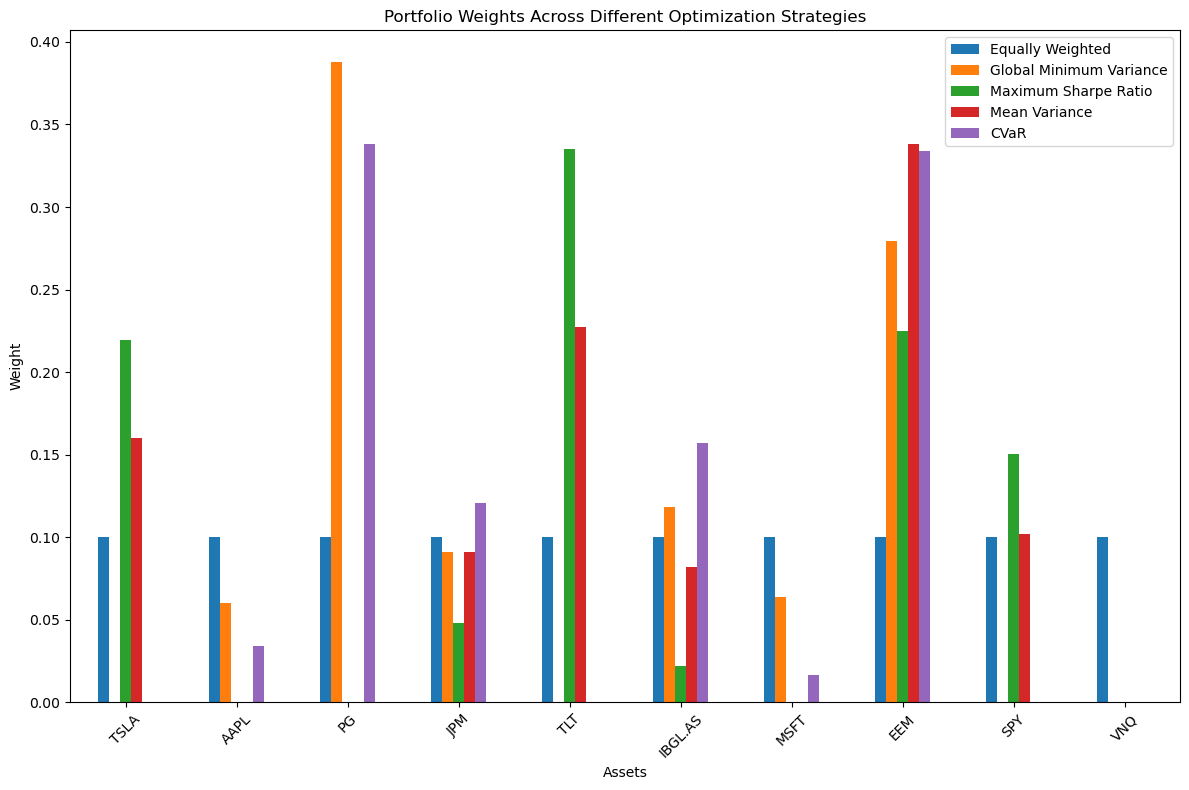

In [56]:
# Plotting the results
fig, ax = plt.subplots(figsize=(12, 8))
weights_df.plot(kind="bar", ax=ax)
ax.set_title("Portfolio Weights Across Different Optimization Strategies")
ax.set_ylabel("Weight")
ax.set_xlabel("Assets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

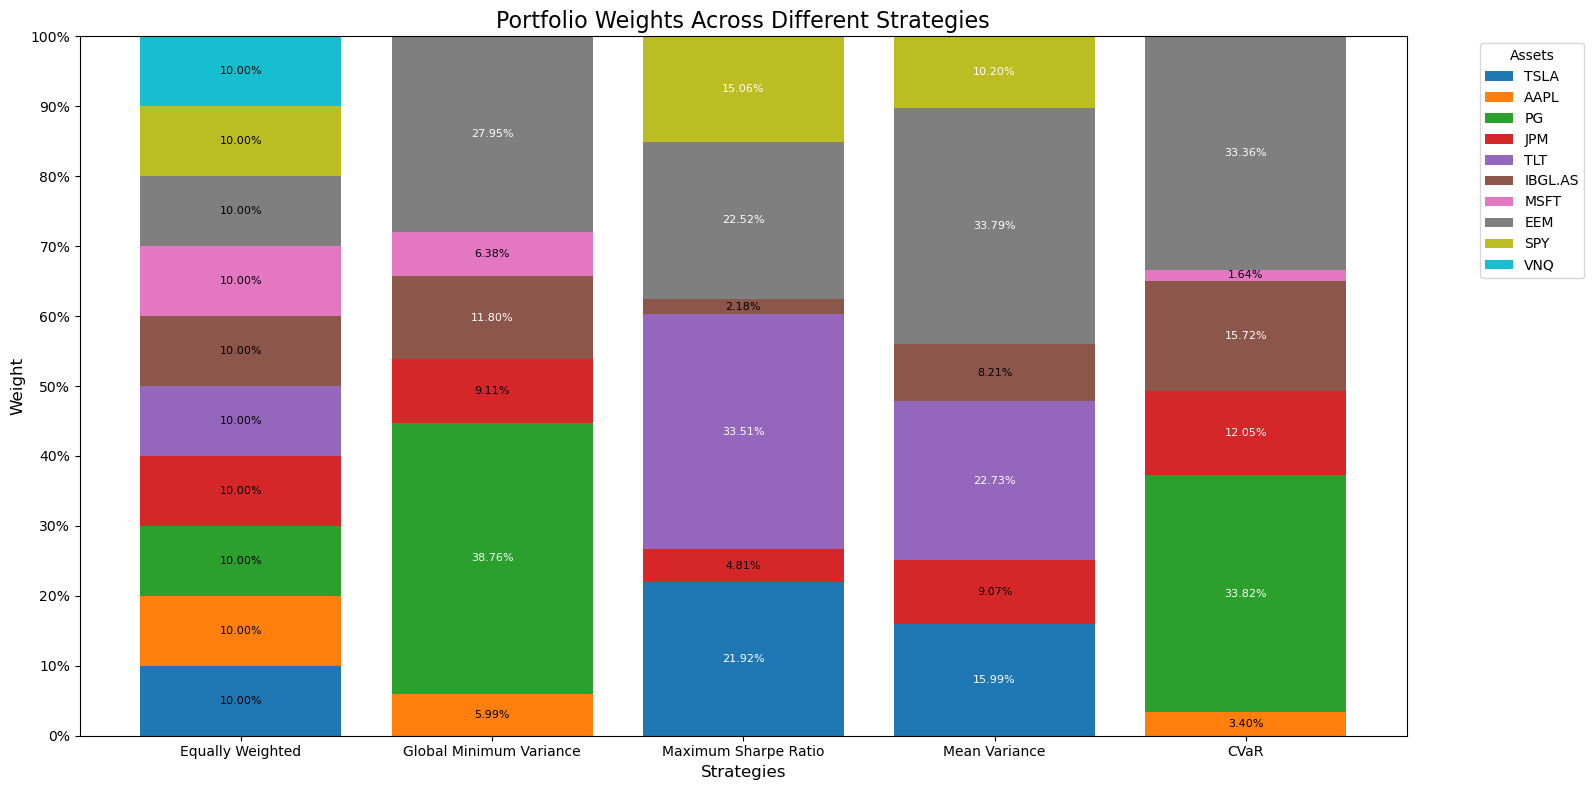

In [58]:
# Transpose for strategies on the x-axis
weights_df_transposed = weights_df

# Use a stacked bar chart for clearer breakdown
fig, ax = plt.subplots(figsize=(16, 8))

bars = []
for i, asset in enumerate(weights_df_transposed.index):
    bar = ax.bar(
        weights_df_transposed.columns,
        weights_df_transposed.loc[asset],
        bottom=weights_df_transposed.iloc[:i].sum(axis=0) if i > 0 else 0,
        label=asset,
    )
    bars.append(bar)

# Label each segment in the bar chart
for i, strategy in enumerate(weights_df_transposed.columns):
    cumulative = 0
    for j, asset in enumerate(weights_df_transposed.index):
        weight = weights_df_transposed.loc[asset, strategy]
        if weight > 0.01:  # Only label segments with significant weights
            ax.text(
                i,
                cumulative + weight / 2,
                f"{weight:.2%}",
                ha="center",
                va="center",
                fontsize=8,
                color="white" if weight > 0.1 else "black",  # Contrast for visibility
            )
        cumulative += weight

# plot the graph
ax.set_title("Portfolio Weights Across Different Strategies", fontsize=16)
ax.set_ylabel("Weight", fontsize=12)
ax.set_xlabel("Strategies", fontsize=12)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels([f"{x:.0%}" for x in np.arange(0, 1.1, 0.1)])
ax.set_xticks(range(len(weights_df_transposed.columns)))
ax.set_xticklabels(weights_df_transposed.columns, fontsize=10, rotation=0)
ax.legend(title="Assets", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()


Performance Metrics Comparison:
                  Strategy  Expected Return  Volatility
0         Equally Weighted         0.158098    0.155244
1            Mean-Variance         0.186175    0.150000
2     Maximum Sharpe Ratio         0.239848    0.195841
3  Global Minimum Variance         0.051545    0.084767
4                     CVaR         0.053689    0.085488


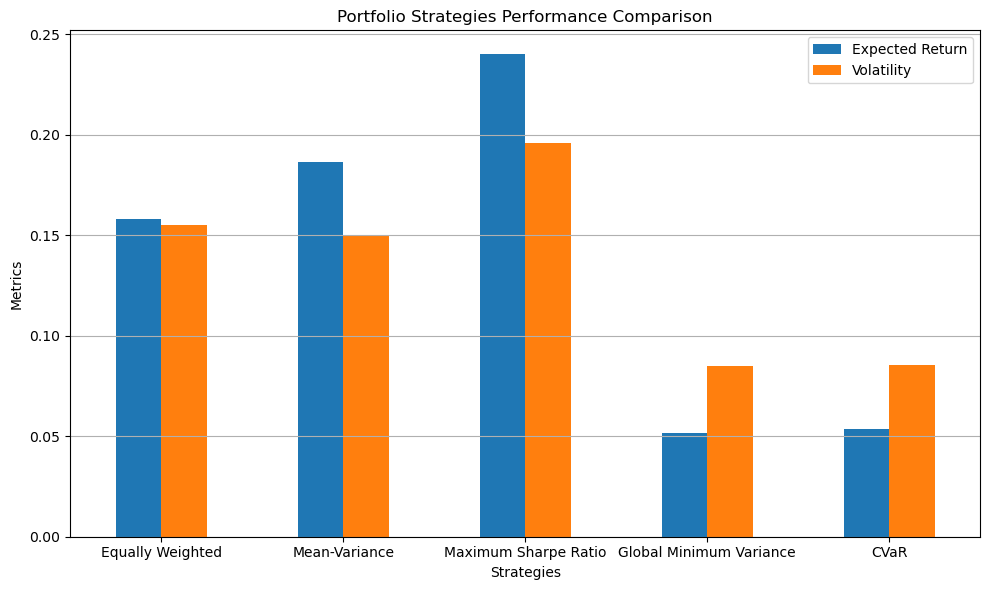

In [60]:
# Calculate performance metrics for each strategy
performance_data = {
    "Strategy": ["Equally Weighted", "Mean-Variance", "Maximum Sharpe Ratio", "Global Minimum Variance", "CVaR"],
    "Expected Return": [
        np.dot(equal_weights, returns.mean()) * 252,  # Annualized return
        np.dot(mv_weights, returns.mean()) * 252,
        np.dot(msr_weights, returns.mean()) * 252,
        np.dot(gmv_weights, returns.mean()) * 252,
        np.dot(cvar_weights, returns.mean()) * 252
    ],
    "Volatility": [
        np.sqrt(np.dot(equal_weights.T, np.dot(returns.cov() * 252, equal_weights))),  # Annualized volatility
        np.sqrt(np.dot(mv_weights.T, np.dot(returns.cov() * 252, mv_weights))),
        np.sqrt(np.dot(msr_weights.T, np.dot(returns.cov() * 252, msr_weights))),
        np.sqrt(np.dot(gmv_weights.T, np.dot(returns.cov() * 252, gmv_weights))),
        np.sqrt(np.dot(cvar_weights.T, np.dot(returns.cov() * 252, cvar_weights)))
    ]
}

# Create a DataFrame for the performance metrics
performance_df = pd.DataFrame(performance_data)

# Print the performance metrics
print("Performance Metrics Comparison:")
print(performance_df)

# Plot performance comparison
performance_df.set_index("Strategy").plot(kind="bar", figsize=(10, 6))
plt.title("Portfolio Strategies Performance Comparison")
plt.ylabel("Metrics")
plt.xlabel("Strategies")
plt.legend(["Expected Return", "Volatility"], loc="best", fontsize=10)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [64]:
# Calculate the efficient frontier
def calculate_efficient_frontier(returns, num_points=100):
    mean_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252
    min_return = np.min(mean_returns)
    max_return = np.max(mean_returns)

    target_returns = np.linspace(min_return, max_return, num_points)
    volatilities = []

    for target_return in target_returns:
        constraints = [
            {"type": "eq", "fun": lambda weights: np.sum(weights) - 1},  # Sum of weights = 1
            {"type": "eq", "fun": lambda weights: np.dot(weights, mean_returns) - target_return},  # Target return
        ]
        result = minimize(
            minimize_volatility,
            init_guess,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
        )
        volatilities.append(result.fun)

    return target_returns, volatilities


In [66]:
# Calculate performance metrics for the defined portfolios
strategy_stats = {
    "Equally Weighted": portfolio_performance(equal_weights, returns),
    "Global Minimum Variance": portfolio_performance(gmv_weights, returns),
    "Maximum Sharpe Ratio": portfolio_performance(msr_weights, returns),
    "Mean Variance": portfolio_performance(mv_weights, returns),
    "CVaR": portfolio_performance(cvar_weights, returns),
}


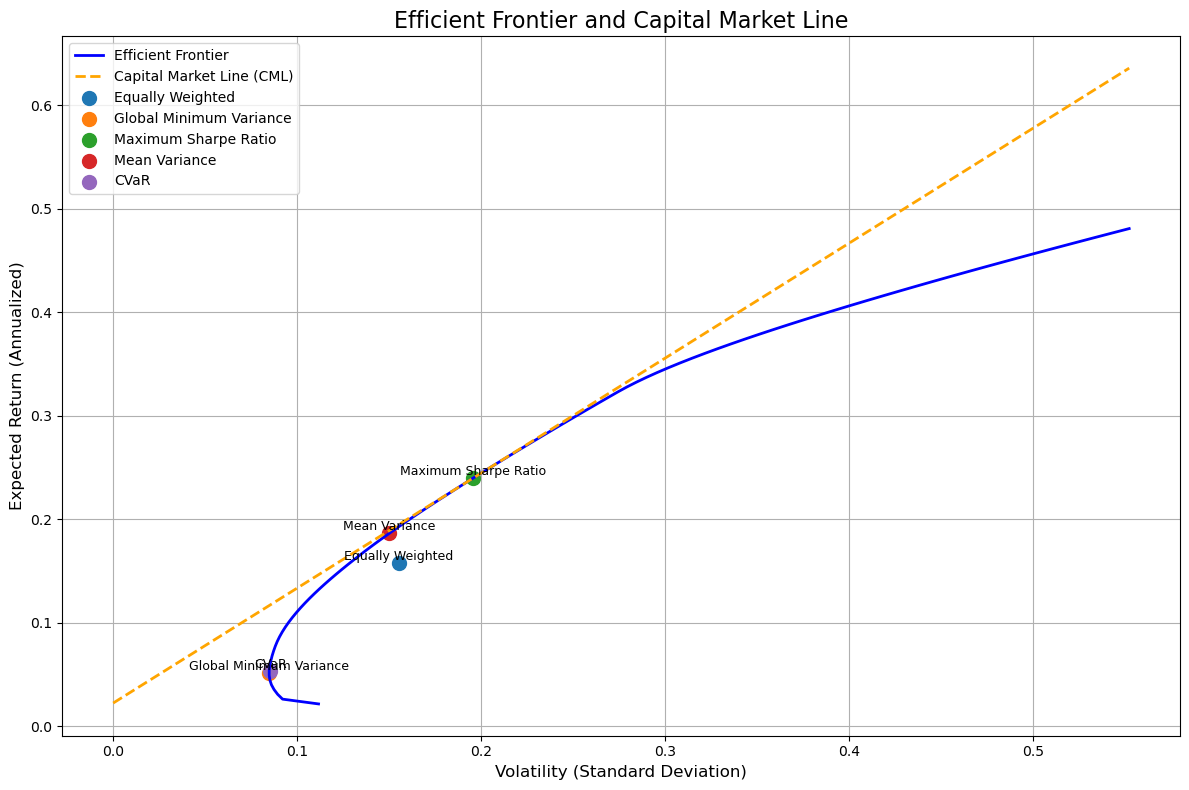

In [68]:
# Calculate the efficient frontier
ef_returns, ef_volatilities = calculate_efficient_frontier(returns)

# Calculate the Sharpe Ratio of the Maximum Sharpe Ratio Portfolio
max_sharpe_return, max_sharpe_volatility = strategy_stats["Maximum Sharpe Ratio"]
max_sharpe_ratio = (max_sharpe_return - tlt_yield) / max_sharpe_volatility

# Calculate the Capital Market Line (CML)
cml_x = np.linspace(0, max(ef_volatilities), 100)
cml_y = tlt_yield + cml_x * max_sharpe_ratio  # CML equation

# Plot the efficient frontier and highlight the portfolios
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the efficient frontier and capital market line
ax.plot(ef_volatilities, ef_returns, label="Efficient Frontier", color="blue", linewidth=2)
ax.plot(cml_x, cml_y, label="Capital Market Line (CML)", color="orange", linestyle="--", linewidth=2)

# Highlight defined portfolios
for name, stats in strategy_stats.items():
    ax.scatter(
        stats[1],  # Volatility
        stats[0],  # Return
        label=f"{name}",
        s=100,
        marker="o",
    )
    ax.text(
        stats[1],
        stats[0],
        f"{name}",
        fontsize=9,
        ha="center",
        va="bottom",
    )

# plot
ax.set_title("Efficient Frontier and Capital Market Line", fontsize=16)
ax.set_xlabel("Volatility (Standard Deviation)", fontsize=12)
ax.set_ylabel("Expected Return (Annualized)", fontsize=12)
ax.legend(loc="best", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Define the function to calculate cumulative values
def calculate_cumulative_value(weights, returns, initial_value=1000):
    """
    Calculate the cumulative value of a portfolio, starting with an initial investment.
    """
    # Compute portfolio returns by taking the dot product of weights and asset returns
    portfolio_returns = np.dot(returns, weights)
    
    # Calculate the cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod() 
    
    # Calculate portfolio value starting with the initial_value
    cumulative_value = initial_value * cumulative_returns
    return cumulative_value

# Calculate cumulative value for each strategy starting with 1000$
equal_cumulative_value = calculate_cumulative_value(equal_weights, returns)
gmv_cumulative_value = calculate_cumulative_value(gmv_weights, returns)
msr_cumulative_value = calculate_cumulative_value(msr_weights, returns)
mv_cumulative_value = calculate_cumulative_value(mv_weights, returns)
cvar_cumulative_value = calculate_cumulative_value(cvar_weights, returns)

# Plotting the cumulative value of each strategy
plt.figure(figsize=(12, 8))

# Plot each strategy's cumulative value
plt.plot(equal_cumulative_value, label="Equally Weighted", color="blue")
plt.plot(gmv_cumulative_value, label="Global Minimum Variance", color="orange")
plt.plot(msr_cumulative_value, label="Maximum Sharpe Ratio", color="green")
plt.plot(mv_cumulative_value, label="Mean Variance", color="indianred")
plt.plot(cvar_cumulative_value, label="Conditional Value at Risk", color="purple")

# Customize the plot
plt.title("Cumulative Portfolio Value of Different Strategies (Starting with $1000)", fontsize=16)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Portfolio Value ($)", fontsize=12)
plt.legend(loc="best", fontsize=10)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
